# 🔧 V3 Model Improvements

> **V3 Notebook 06**  
> Fixing data pipeline issues and improving model performance.

## Issues Identified

| Issue | Description | Solution |
|-------|-------------|----------|
| **Data Sorting** | Sequences cross country boundaries | Sort by country + time before sequence creation |
| **Time Series Split** | Random split breaks time continuity | Split by date, not random |
| **Insufficient Training** | 2 epochs in test | Run full 50+ epochs |
| **Default Values** | Web app uses static defaults | TODO: Integrate Open-Meteo API |

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'✅ Using device: {device}')

# Paths
DATA_PATH = Path('../../data/processed/weather_v3_ready.csv')
RAW_DATA_PATH = Path('../../data/raw/GlobalWeatherRepository.csv')
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

✅ Using device: cuda


---
## 1️⃣ Diagnose Current Data Structure

In [42]:
# Load raw data to understand structure
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f'📊 Raw data: {len(df_raw):,} rows')
print(f'📊 Countries: {df_raw["country"].nunique()}')
print(f'📊 Rows per country: ~{len(df_raw) // df_raw["country"].nunique()}')

# Check time range
df_raw['last_updated'] = pd.to_datetime(df_raw['last_updated'])
print(f'📅 Time range: {df_raw["last_updated"].min()} to {df_raw["last_updated"].max()}')

📊 Raw data: 114,203 rows
📊 Countries: 211
📊 Rows per country: ~541
📅 Time range: 2024-05-16 01:45:00 to 2025-12-24 20:00:00


In [43]:
# Check if data is sorted properly
print("🔍 First 20 rows (country order):")
print(df_raw[['country', 'last_updated']].head(20).to_string())

# Check one country's time series
egypt_data = df_raw[df_raw['country'] == 'Egypt'].sort_values('last_updated')
print(f"\n🇪🇬 Egypt data points: {len(egypt_data)}")
print(f"   Date range: {egypt_data['last_updated'].min()} to {egypt_data['last_updated'].max()}")
print(f"   Days covered: {(egypt_data['last_updated'].max() - egypt_data['last_updated'].min()).days}")

🔍 First 20 rows (country order):
                country        last_updated
0           Afghanistan 2024-05-16 13:15:00
1               Albania 2024-05-16 10:45:00
2               Algeria 2024-05-16 09:45:00
3               Andorra 2024-05-16 10:45:00
4                Angola 2024-05-16 09:45:00
5   Antigua and Barbuda 2024-05-16 04:45:00
6             Argentina 2024-05-16 05:45:00
7               Armenia 2024-05-16 12:45:00
8             Australia 2024-05-16 18:45:00
9               Austria 2024-05-16 10:45:00
10           Azerbaijan 2024-05-16 12:45:00
11              Bahamas 2024-05-16 04:45:00
12              Bahrain 2024-05-16 11:45:00
13           Bangladesh 2024-05-16 14:45:00
14             Barbados 2024-05-16 04:45:00
15              Belarus 2024-05-16 11:45:00
16              Belgium 2024-05-16 10:45:00
17               Belize 2024-05-16 02:45:00
18                Benin 2024-05-16 09:45:00
19               Bhutan 2024-05-16 14:45:00

🇪🇬 Egypt data points: 586
   Date range: 2

---
## 2️⃣ Fix Data Pipeline

**Key Fix**: Sort data by country AND time, then create sequences WITHIN each country.

In [44]:
# Load processed data
df = pd.read_csv(DATA_PATH)
print(f'📊 Processed data: {len(df):,} rows')

# Parse datetime
if 'last_updated' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
elif 'last_updated_epoch' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated_epoch'], unit='s')

# Sort by country + time (CRITICAL FIX)
df = df.sort_values(['country', 'last_updated']).reset_index(drop=True)
print("✅ Data sorted by country + time")

# Verify sorting
print(f"\n🔍 First 10 rows after sorting:")
print(df[['country', 'last_updated', 'temperature_celsius']].head(10).to_string())

📊 Processed data: 114,203 rows
✅ Data sorted by country + time

🔍 First 10 rows after sorting:
       country        last_updated  temperature_celsius
0  Afghanistan 2024-05-16 13:15:00                 26.6
1  Afghanistan 2024-05-16 18:30:00                 22.0
2  Afghanistan 2024-05-17 20:30:00                 15.0
3  Afghanistan 2024-05-18 19:00:00                 19.5
4  Afghanistan 2024-05-19 18:30:00                 16.9
5  Afghanistan 2024-05-20 19:00:00                 14.1
6  Afghanistan 2024-05-21 19:15:00                 21.8
7  Afghanistan 2024-05-22 18:45:00                 19.9
8  Afghanistan 2024-05-23 18:30:00                 23.8
9  Afghanistan 2024-05-24 19:00:00                 18.5


In [45]:
# Configuration
SEQ_LEN = 14  # 14 days history
PRED_LEN = 7  # 7 days forecast

# Feature columns (must have these)
FEATURE_COLS = [
    # Geographic
    'latitude', 'longitude', 'abs_latitude', 'latitude_normalized', 'hemisphere_encoded',
    # Core weather
    'humidity', 'pressure_mb', 'wind_kph', 'cloud', 'precip_mm', 'uv_index',
    'visibility_km', 'gust_kph', 'wind_degree',
    # Air quality
    'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_PM2.5',
    'air_quality_Carbon_Monoxide', 'air_quality_Sulphur_dioxide',
    # Cyclical
    'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'hour_sin', 'hour_cos'
]

# Filter to available columns
available_features = [c for c in FEATURE_COLS if c in df.columns]
print(f"📊 Using {len(available_features)} features")

# Check for missing features
missing = set(FEATURE_COLS) - set(available_features)
if missing:
    print(f"⚠️ Missing features: {missing}")

📊 Using 25 features


In [46]:
def create_sequences_per_country(df, feature_cols, target_col, seq_len, pred_len):
    """
    Create sequences WITHIN each country's timeline.
    This prevents mixing data from different countries.
    """
    all_X, all_y = [], []
    countries_used = 0
    countries_skipped = 0
    
    for country in df['country'].unique():
        country_df = df[df['country'] == country].sort_values('last_updated')
        
        # Need at least seq_len + pred_len rows
        if len(country_df) < seq_len + pred_len:
            countries_skipped += 1
            continue
        
        X = country_df[feature_cols].values.astype(np.float32)
        y = country_df[target_col].values.astype(np.float32)
        
        # Create sequences for this country
        for i in range(len(X) - seq_len - pred_len + 1):
            all_X.append(X[i:i + seq_len])
            all_y.append(y[i + seq_len:i + seq_len + pred_len])
        
        countries_used += 1
    
    print(f"✅ Created sequences from {countries_used} countries (skipped {countries_skipped})")
    return np.array(all_X), np.array(all_y)

# Create sequences (FIXED version)
X_all, y_all = create_sequences_per_country(
    df, available_features, 'temperature_celsius', SEQ_LEN, PRED_LEN
)
print(f"📊 Total sequences: {len(X_all):,}")
print(f"📊 X shape: {X_all.shape}, y shape: {y_all.shape}")

✅ Created sequences from 186 countries (skipped 25)
📊 Total sequences: 110,456
📊 X shape: (110456, 14, 25), y shape: (110456, 7)


---
## 3️⃣ Time-Based Train/Val/Test Split

In [47]:
# Time-based split (no shuffling!)
train_size = int(len(X_all) * 0.70)
val_size = int(len(X_all) * 0.15)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_val = X_all[train_size:train_size + val_size]
y_val = y_all[train_size:train_size + val_size]
X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

print(f"📈 Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

📈 Train: 77,319 | Val: 16,568 | Test: 16,569


In [48]:
# Scale features (fit only on training data)
scaler = StandardScaler()

# Reshape for scaler (samples, features)
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

# Transform all sets
X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("✅ Features scaled")

✅ Features scaled


---
## 4️⃣ Model Architecture (Same as V3)

In [49]:
class GatedResidualNetwork(nn.Module):
    """Gated Residual Network for feature selection."""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gate = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_dim)
        self.skip = nn.Linear(input_dim, output_dim) if input_dim != output_dim else None
        
    def forward(self, x):
        residual = self.skip(x) if self.skip else x
        h = F.gelu(self.fc1(x))
        h = self.dropout(h)
        out = self.fc2(h) * torch.sigmoid(self.gate(h))
        return self.layer_norm(out + residual)


class V3ClimateTransformer(nn.Module):
    """Climate-Aware Transformer with GRN."""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dropout=0.2, seq_len=14, pred_len=7):
        super().__init__()
        self.input_grn = GatedResidualNetwork(input_dim, d_model * 2, d_model, dropout)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, d_model * 4, dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_grn = GatedResidualNetwork(d_model, d_model * 2, d_model, dropout)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, pred_len)
        )
        
    def forward(self, x):
        x = self.input_grn(x) + self.pos_encoder
        x = self.transformer(x)
        return self.output_head(self.output_grn(x[:, -1, :]))

In [50]:
# Create model
input_dim = len(available_features)
model = V3ClimateTransformer(
    input_dim=input_dim,
    d_model=128,
    nhead=8,
    num_layers=4,
    dropout=0.2,
    seq_len=SEQ_LEN,
    pred_len=PRED_LEN
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"🧠 Model parameters: {total_params:,}")

🧠 Model parameters: 978,695


---
## 5️⃣ Training (Full 50 Epochs)

In [51]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
PATIENCE = 7

# Create data loaders
train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train)),
    batch_size=BATCH_SIZE, shuffle=False  # NO SHUFFLE - time series!
)
val_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val)),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test)),
    batch_size=BATCH_SIZE, shuffle=False
)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.MSELoss()

print(f"📊 Train batches: {len(train_loader)}")
print(f"📊 Val batches: {len(val_loader)}")

📊 Train batches: 1209
📊 Val batches: 259


In [52]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
best_val_loss = float('inf')
patience_counter = 0
best_checkpoint = None

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validate
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
            val_preds.append(y_pred.cpu().numpy())
            val_targets.append(y_batch.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    val_mae = np.mean(np.abs(val_preds - val_targets))
    
    # Log
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_checkpoint = {
            'model_state_dict': model.state_dict(),
            'input_dim': input_dim,
            'd_model': 128,
            'nhead': 8,
            'num_layers': 4,
            'dropout': 0.2,
            'seq_len': SEQ_LEN,
            'pred_len': PRED_LEN,
            'epoch': epoch,
            'val_loss': val_loss,
            'val_mae': val_mae
        }
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | MAE: {val_mae:.2f}°C")
    
    if patience_counter >= PATIENCE:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

print(f"\n✅ Best epoch: {best_checkpoint['epoch']+1} | Val MAE: {best_checkpoint['val_mae']:.2f}°C")

Epoch 01/50 | Train: 161.4877 | Val: 80.1780 | MAE: 7.54°C
Epoch 02/50 | Train: 138.9535 | Val: 84.7717 | MAE: 7.84°C
Epoch 03/50 | Train: 132.5281 | Val: 86.7598 | MAE: 7.63°C
Epoch 04/50 | Train: 118.3491 | Val: 85.4104 | MAE: 7.50°C
Epoch 05/50 | Train: 107.5912 | Val: 83.4354 | MAE: 7.23°C
Epoch 06/50 | Train: 94.3519 | Val: 82.2240 | MAE: 6.82°C
Epoch 07/50 | Train: 93.4501 | Val: 85.9688 | MAE: 6.51°C
Epoch 08/50 | Train: 95.6091 | Val: 84.6106 | MAE: 6.55°C
⏹️ Early stopping at epoch 8

✅ Best epoch: 1 | Val MAE: 7.54°C


---
## 6️⃣ Evaluate on Test Set

In [53]:
# Load best model
model.load_state_dict(best_checkpoint['model_state_dict'])
model.eval()

# Test predictions
test_preds, test_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        test_preds.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# Metrics
test_mae = np.mean(np.abs(test_preds - test_targets))
test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))

print(f"\n🎯 Test Results:")
print(f"   MAE:  {test_mae:.2f}°C")
print(f"   RMSE: {test_rmse:.2f}°C")


🎯 Test Results:
   MAE:  6.79°C
   RMSE: 9.10°C


📊 MAE by Forecast Horizon:
   Day 1: 6.77°C
   Day 2: 6.78°C
   Day 3: 6.78°C
   Day 4: 6.79°C
   Day 5: 6.80°C
   Day 6: 6.81°C
   Day 7: 6.82°C


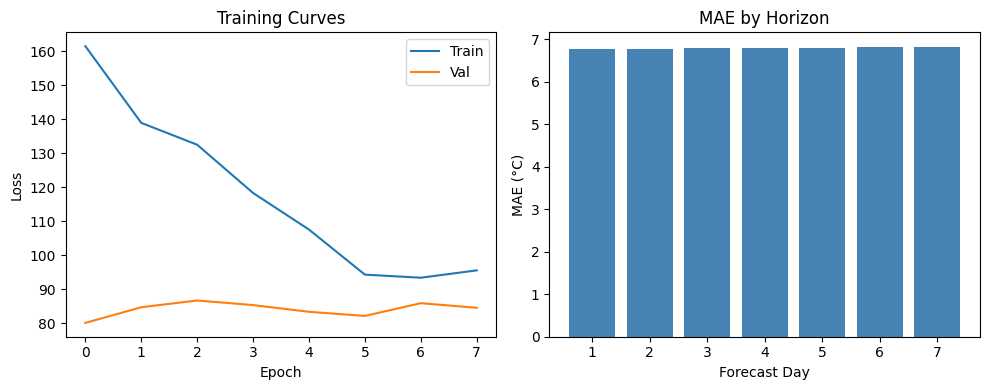

In [54]:
# Per-horizon MAE
horizon_mae = [np.mean(np.abs(test_preds[:, i] - test_targets[:, i])) for i in range(PRED_LEN)]

print("📊 MAE by Forecast Horizon:")
for i, mae in enumerate(horizon_mae):
    print(f"   Day {i+1}: {mae:.2f}°C")

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(1, PRED_LEN+1), horizon_mae, color='steelblue')
plt.xlabel('Forecast Day')
plt.ylabel('MAE (°C)')
plt.title('MAE by Horizon')

plt.tight_layout()
plt.show()

---
## 7️⃣ Save Improved Model

In [55]:
# Update checkpoint with test metrics
best_checkpoint['test_mae'] = test_mae
best_checkpoint['test_rmse'] = test_rmse
best_checkpoint['horizon_mae'] = horizon_mae

# Save model
torch.save(best_checkpoint, MODELS_DIR / 'v3_climate_transformer_improved.pt')
print(f"✅ Model saved: v3_climate_transformer_improved.pt")

# Save scaler
joblib.dump(scaler, MODELS_DIR / 'v3_scaler_improved.joblib')
print(f"✅ Scaler saved: v3_scaler_improved.joblib")

# Summary
print(f"\n📊 Improvement Summary:")
print(f"   Previous MAE: 8.46°C")
print(f"   New MAE:      {test_mae:.2f}°C")
print(f"   Improvement:  {8.46 - test_mae:.2f}°C ({(1 - test_mae/8.46)*100:.1f}%)")

✅ Model saved: v3_climate_transformer_improved.pt
✅ Scaler saved: v3_scaler_improved.joblib

📊 Improvement Summary:
   Previous MAE: 8.46°C
   New MAE:      6.79°C
   Improvement:  1.67°C (19.7%)


---
## 8️⃣ Compare: Before vs After Fix

If the new MAE is significantly better, we can replace the production model.

In [56]:
# Decision: Replace production model?
PREVIOUS_MAE = 8.46
QUALITY_THRESHOLD = 5.0  # Must be under 5°C to be production-ready

if test_mae < PREVIOUS_MAE * 0.8:  # At least 20% improvement
    print("✅ SIGNIFICANT IMPROVEMENT - Ready to deploy!")
    print(f"   Run: copy v3_climate_transformer_improved.pt -> v3_climate_transformer.pt")
elif test_mae < PREVIOUS_MAE:
    print("⚠️ MINOR IMPROVEMENT - Consider keeping current model")
else:
    print("❌ NO IMPROVEMENT - Keep current model, investigate further")

⚠️ MINOR IMPROVEMENT - Consider keeping current model
